## Zadanie 2

##### Rekurenycjne odwracanie macierzy

In [2]:
import numpy as np

def multi_dot(dot_m, arrays): 
    '''
    function used to make multiple dots in one go
    '''
    result, op = dot_m(arrays[0], arrays[1])
    for i in range(2, len(arrays)):
        result, op_new = dot_m(result, arrays[i])
        op+=op_new
    return result, op


def recursive_inversion(matrix, dot_method):   
    '''
    function returns inverted matrix and operations it took to invert
    '''
    cnt = 0
    if matrix.shape[0] != matrix.shape[1]: raise Exception('Matrix is not a square')
    
    if matrix.shape == (1, 1):
        if matrix[0, 0] == 0: raise Exception('Matrix is invertible')
        cnt += 1
        return np.array([[1/matrix[0, 0]]]), cnt
    
    if matrix.shape == (2, 2):
        det = matrix[0, 0]*matrix[1, 1] - matrix[0, 1]*matrix[1, 0]
        if det == 0: raise Exception('Matrix is invertible')
        cnt += 6
        return np.array([[matrix[1, 1]/det, -matrix[0, 1]/det], [-matrix[1, 0]/det, matrix[0, 0]/det]]), cnt
    
    else:
        n = matrix.shape[0]
        m = n//2
        A = matrix[:m, :m]
        B = matrix[:m, m:]
        C = matrix[m:, :m]
        D = matrix[m:, m:]
        
        A_inv, cnt1 = recursive_inversion(A, dot_method)
        md_val_1, md_cnt_1 = multi_dot(dot_method, [C, A_inv, B])
        Common, cnt2 = recursive_inversion(D - md_val_1, dot_method)

        md_val_2, md_cnt_2 =multi_dot(dot_method, [A_inv, B, Common, C, A_inv])
        P = A_inv+md_val_2
        md_val_3, md_cnt_3 =multi_dot(dot_method, [A_inv, B, Common])
        Q = -md_val_3
        md_val_4, md_cnt_4 = multi_dot(dot_method, [Common, C, A_inv])
        R = -md_val_4

        S = Common  

        Top = np.row_stack([P, R])
        Bottom = np.row_stack([Q,S])
        cnt += cnt1 + cnt2 + md_cnt_1 + md_cnt_2 + md_cnt_3 + md_cnt_4

        return np.column_stack([Top, Bottom]), cnt
    



In [56]:
def assert_same(A, B, sigma = 1e-5):
    for i,row in enumerate(A):
        for j, el in enumerate(row):
            assert abs(el-B[i][j]) < sigma

In [15]:
import time
from matplotlib import pyplot as plt
from multi_algorithms import cauchy_binet_recursive, strassen_matrix_multiply


def test_algorithm(max_k):
    x = []
    y_t = [[] for _ in range(2)]
    y_op = [[] for _ in range(2)]
    for k in range(2,max_k+1):
        n = 2**k
        A = np.random.rand(n,n)

        start = time.time()
        A_inv, ops = recursive_inversion(A, cauchy_binet_recursive)
        end = time.time()

        assert_same(A_inv, np.linalg.inv(A))
        y_t[0].append(end-start)
        y_op[0].append(ops)

        start = time.time()
        A_inv, ops = recursive_inversion(A, strassen_matrix_multiply)
        end = time.time()

        assert_same(A_inv, np.linalg.inv(A))
        y_t[1].append(end-start)
        y_op[1].append(ops)

        x.append(k)


    return x, y_t, y_op


In [124]:
x, y_t, y_op = test_algorithm(8)


['0.0s', '0.0s', '0.01s', '0.09s', '0.67s', '5.44s', '43.34s']
['0.0s', '0.0s', '0.03s', '0.18s', '1.26s', '8.84s', '62.44s']


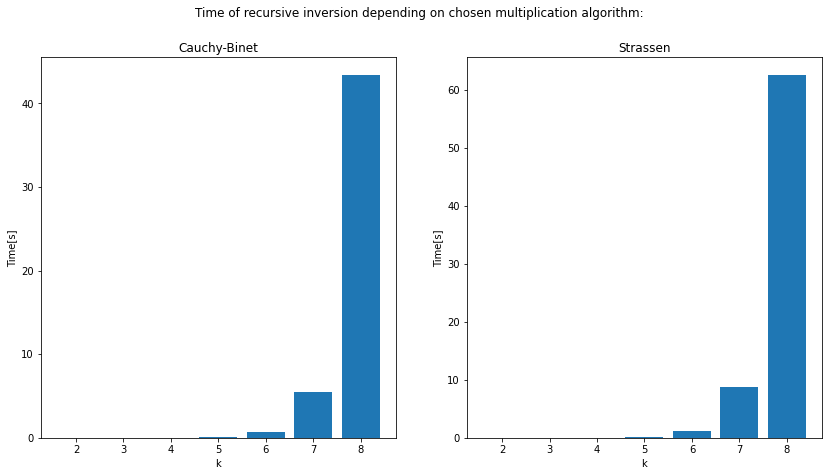

In [142]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Time of recursive inversion depending on chosen multiplication algorithm:')
plt.bar(x, y_t[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('Time[s]')
plt.subplot(1,2,2)
plt.bar(x, y_t[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('Time[s]')

print([str(round(el,2)) + 's' for el in y_t[0]])
print([str(round(el,2)) + 's' for el in y_t[1]])


[132, 1384, 12368, 104096, 853312, 6908544, 55596288]
[262, 2994, 26158, 205026, 1525102, 11039874, 78744718]


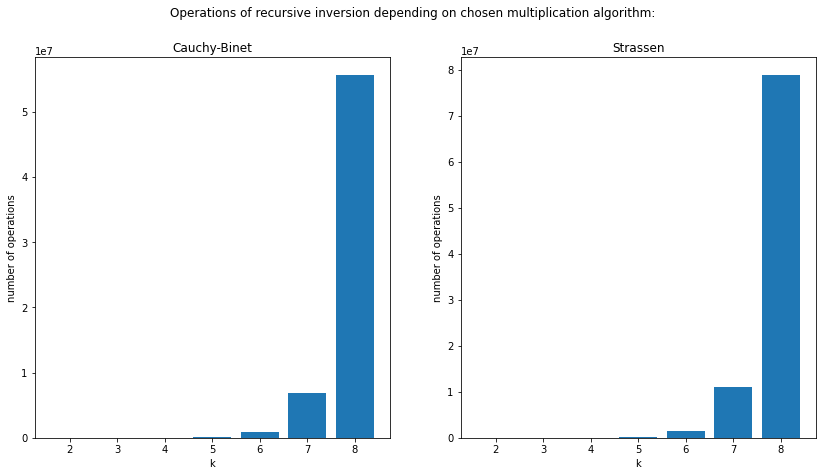

In [144]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Operations of recursive inversion depending on chosen multiplication algorithm:')
plt.bar(x, y_op[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('number of operations')
plt.subplot(1,2,2)
plt.bar(x, y_op[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('number of operations')

print(y_op[0])
print(y_op[1])

## LU faktoryzacja

In [54]:
def test_lu(max_k):
    x = []
    y_t = [[] for _ in range(2)]
    y_op = [[] for _ in range(2)]
    for k in range(2,max_k+1):
        n = 2**k
        A = np.random.rand(n,n)

        start = time.time()
        L, U, ops = lu_decomposition(A, cauchy_binet_recursive)
        end = time.time()
         
        assert_same(A, L @ U)
        y_t[0].append(end-start)
        y_op[0].append(ops)

        start = time.time()
        L, U, ops = lu_decomposition(A, strassen_matrix_multiply)
        end = time.time()

        assert_same(A, L @ U)
        y_t[1].append(end-start)
        y_op[1].append(ops)

        x.append(k)


    return x, y_t, y_op

In [31]:
def strassen_matrix_multiply(A, B):
    if A.shape[1] != B.shape[0]:
        raise ValueError("Matrix dimensions are not compatible for multiplication")

    if A.shape[0] == 1 and A.shape[1] == 1:
        return A * B, 1

    # Split the matrices into four equal-sized parts
    m = A.shape[0] // 2

    a11, a12 = A[:m, :m], A[:m, m:]
    a21, a22 = A[m:, :m], A[m:, m:]

    b11, b12 = B[:m, :m], B[:m, m:]
    b21, b22 = B[m:, :m], B[m:, m:]

    # Calculate the 7 products P1 to P7 using Strassen's method
    p1, count1 = strassen_matrix_multiply(a11, (b12 - b22))
    p2, count2 = strassen_matrix_multiply((a11 + a12), b22)
    p3, count3 = strassen_matrix_multiply((a21 + a22), b11)
    p4, count4 = strassen_matrix_multiply(a22, (b21 - b11))
    p5, count5 = strassen_matrix_multiply((a11 + a22), (b11 + b22))
    p6, count6 = strassen_matrix_multiply((a12 - a22), (b21 + b22))
    p7, count7 = strassen_matrix_multiply((a11 - a21), (b11 + b12))

    # Calculate the four parts of the result matrix
    c11 = p5 + p4 - p2 + p6
    c12 = p1 + p2
    c21 = p3 + p4
    c22 = p5 + p1 - p3 - p7

    # Combine the results
    top = np.hstack((c11, c12))
    bottom = np.hstack((c21, c22))
    result = np.vstack((top, bottom))
    
    count = count1 + count2 + count3 + count4 + count5 + count6 + count7 + 18*(A.shape[0]//2)**2
    
    return result, count

In [32]:
def cauchy_binet_recursive(A, B):
    if A.shape[1] != B.shape[0]:
        raise ValueError("Matrix dimensions are not compatible for multiplication")

    if A.shape[0] == 1 and A.shape[1] == 1:
        return A * B, 1

    
    # Split matrices A and B into submatrices
    m = A.shape[0] // 2
    A11, A12 = A[:m, :m], A[:m, m:]
    A21, A22 = A[m:, :m], A[m:, m:]
    B11, B12 = B[:m, :m], B[:m, m:]
    B21, B22 = B[m:, :m], B[m:, m:]

    # Recursively compute subdeterminants
    LU1, count1 = cauchy_binet_recursive(A11, B11)
    LU2, count2 = cauchy_binet_recursive(A12, B21)
    RU1, count3 = cauchy_binet_recursive(A11, B12)
    RU2, count4 = cauchy_binet_recursive(A12, B22)
    LD1, count5 = cauchy_binet_recursive(A21, B11)
    LD2, count6 = cauchy_binet_recursive(A22, B21)
    RD1, count7 = cauchy_binet_recursive(A21, B12)
    RD2, count8 = cauchy_binet_recursive(A22, B22)
    
    result = np.zeros((2*m, 2*m))
    result[:m, :m] = LU1 + LU2
    result[:m, m:] = RU1 + RU2
    result[m:, :m] = LD1 + LD2
    result[m:, m:] = RD1 + RD2
    
    count = count1 + count2 + count3 + count4 + count5 + count6 + count7 + count8 + 4*(m)**2

    return result, count


In [39]:
def lu_decomposition(A, dot_method):
    n = len(A)
    
    if n == 1:
        L = np.array([[1]])
        U = A
        return L, U, 0

    A11 = A[:n//2, :n//2]
    A12 = A[:n//2, n//2:]
    A21 = A[n//2:, :n//2]
    A22 = A[n//2:, n//2:]

    L11, U11, count1 = lu_decomposition(A11, dot_method)
    U11_inv, count2 = recursive_inversion(U11, dot_method)
    L21, count3 = dot_method(A21, U11_inv)
    L11_inv, count4 = recursive_inversion(L11, dot_method)
    U12, count5 = dot_method(L11_inv, A12)
    A21U11_inv, count6 = dot_method(A21, U11_inv)
    L11_invA12, count7 = dot_method(L11_inv, A12)
    tmp, count8 = dot_method(A21U11_inv, L11_invA12)
    S, count9 = A22 - tmp, tmp.shape[0]*tmp.shape[0]
    Ls, Us, count10 = lu_decomposition(S, dot_method)
    U22 = Us
    L22 = Ls

    L1 = np.hstack((L11, np.zeros((n//2, n//2))))
    L2 = np.hstack((L21, L22))
    L = np.vstack((L1, L2))

    U1 = np.hstack((U11, U12))
    U2 = np.hstack((np.zeros((n//2, n//2)), U22))
    U = np.vstack((U1, U2))
    
    count = count1 + count2 + count3 + count4 + count5 + count6 + count7 + count8 + count9 + count10

    return L, U, count

In [57]:
x, y_t, y_op = test_lu(8)

['0.0s', '0.0s', '0.02s', '0.09s', '0.72s', '5.9s', '46.98s']
['0.0s', '0.01s', '0.02s', '0.14s', '1.05s', '7.11s', '49.79s']


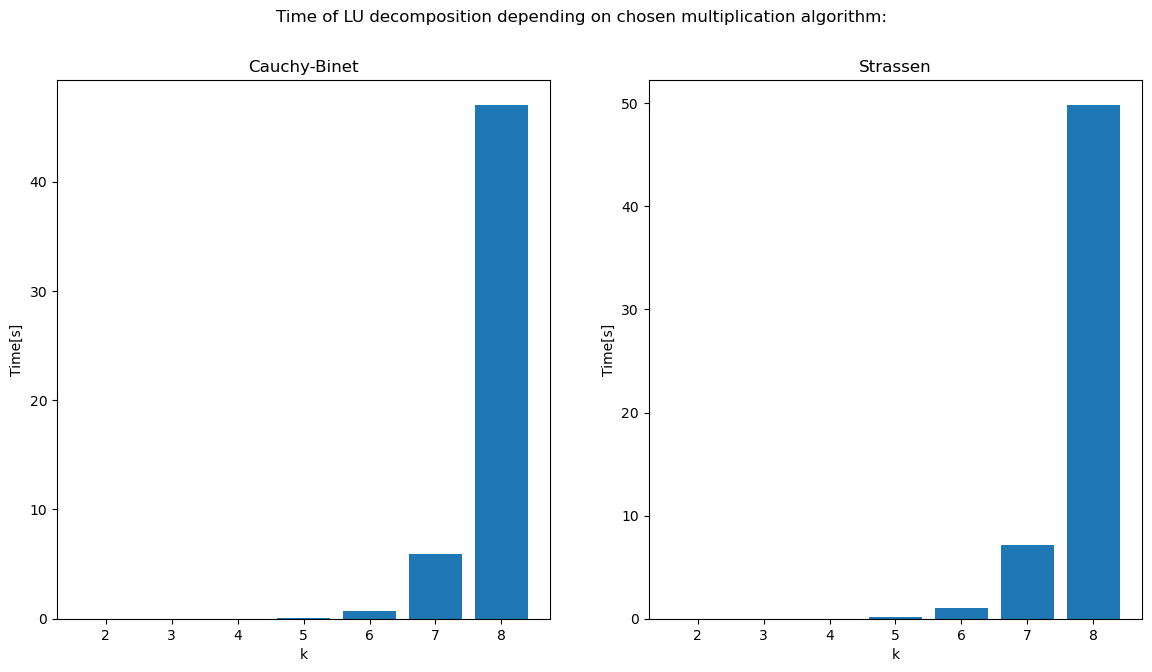

In [58]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Time of LU decomposition depending on chosen multiplication algorithm:')
plt.bar(x, y_t[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('Time[s]')
plt.subplot(1,2,2)
plt.bar(x, y_t[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('Time[s]')

print([str(round(el,2)) + 's' for el in y_t[0]])
print([str(round(el,2)) + 's' for el in y_t[1]])

[92, 1024, 9680, 84032, 699840, 5711360, 46145792]
[157, 2089, 20315, 169557, 1307715, 9664565, 69757747]


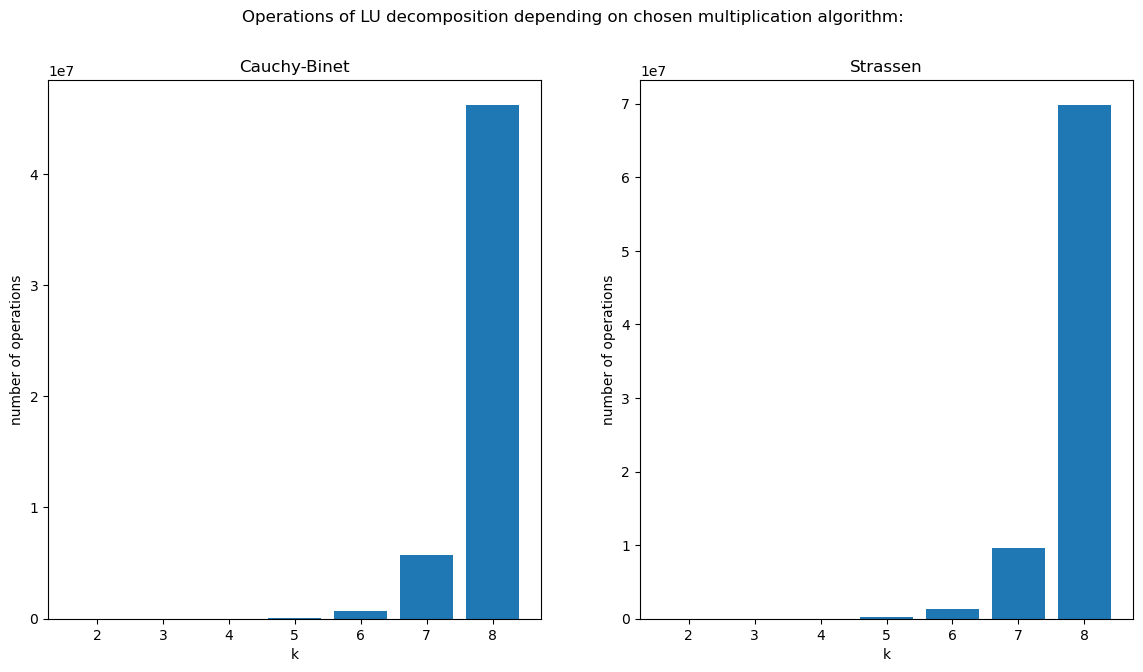

In [59]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Operations of LU decomposition depending on chosen multiplication algorithm:')
plt.bar(x, y_op[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('number of operations')
plt.subplot(1,2,2)
plt.bar(x, y_op[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('number of operations')

print(y_op[0])
print(y_op[1])

## Wyznacznik

In [74]:
def det(A, dot_method):
    
    L, U, count = lu_decomposition(A, dot_method)

    det_L = np.prod(np.diagonal(L))  
    det_U = np.prod(np.diagonal(U))  

    return det_U*det_L, count + 2*U.shape[0] + 1

In [77]:
def test_det(max_k, sigma=10e-4):
    x = []
    y_t = [[] for _ in range(2)]
    y_op = [[] for _ in range(2)]
    for k in range(2,max_k+1):
        n = 2**k
        A = np.random.rand(n,n)

        start = time.time()
        detA, ops = det(A, cauchy_binet_recursive)
        end = time.time()
        print(detA - np.linalg.det(A), "ch")

        y_t[0].append(end-start)
        y_op[0].append(ops)

        start = time.time()
        detA, ops = det(A, strassen_matrix_multiply)
        end = time.time()
        print(detA - np.linalg.det(A), "st")

        y_t[1].append(end-start)
        y_op[1].append(ops)

        x.append(k)


    return x, y_t, y_op

In [78]:
x, y_t, y_op = test_det(8)

5.551115123125783e-17 ch
1.1102230246251565e-16 st
8.673617379884035e-18 ch
-6.418476861114186e-17 st
2.0886070650760757e-15 ch
5.10702591327572e-15 st
7.629452625224076e-13 ch
1.9169554832387803e-11 st
0.02382659912109375 ch
-8.657610893249512 st
1.793985470017129e+28 ch
5.472206349263078e+30 st
-1.3406993040236908e+107 ch
3.0058317484549826e+110 st


['0.0s', '0.0s', '0.01s', '0.09s', '0.72s', '5.83s', '46.54s']
['0.0s', '0.0s', '0.02s', '0.15s', '1.1s', '7.54s', '53.19s']


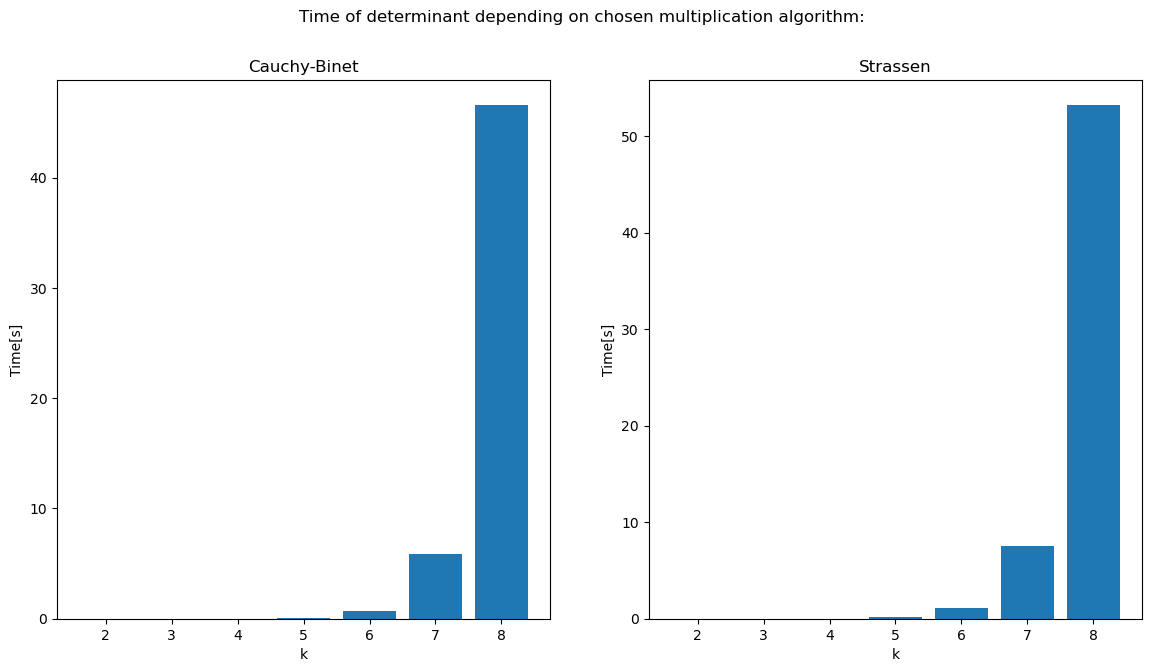

In [79]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Time of determinant depending on chosen multiplication algorithm:')
plt.bar(x, y_t[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('Time[s]')
plt.subplot(1,2,2)
plt.bar(x, y_t[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('Time[s]')

print([str(round(el,2)) + 's' for el in y_t[0]])
print([str(round(el,2)) + 's' for el in y_t[1]])

[101, 1041, 9713, 84097, 699969, 5711617, 46146305]
[166, 2106, 20348, 169622, 1307844, 9664822, 69758260]


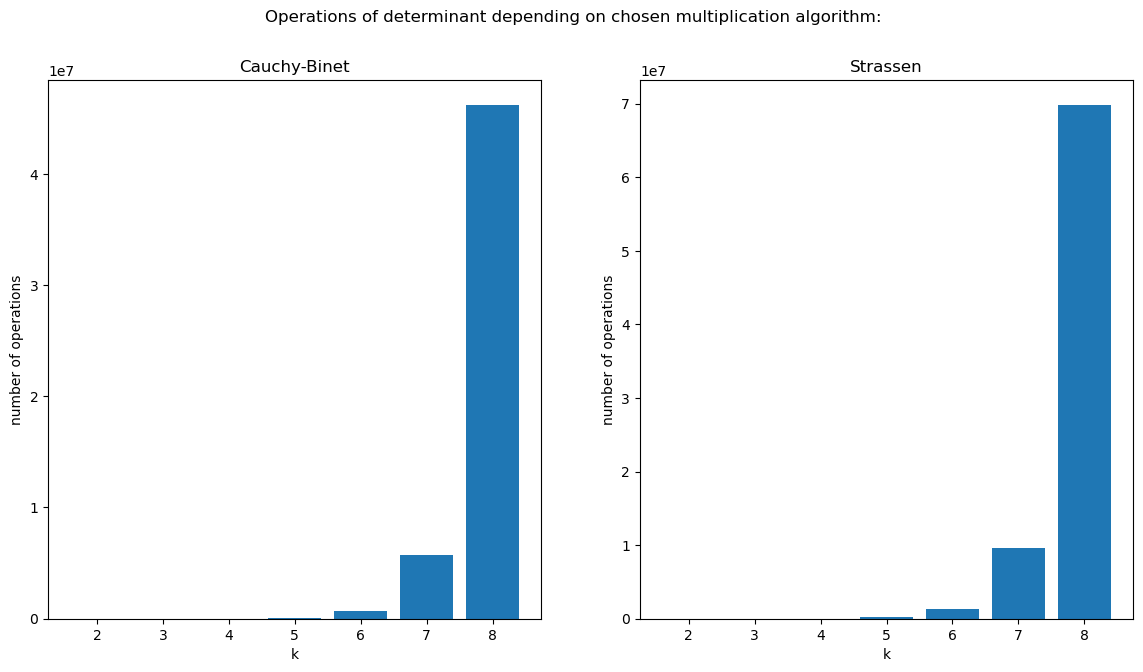

In [80]:
# plot two bars on one plot
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.suptitle('Operations of determinant depending on chosen multiplication algorithm:')
plt.bar(x, y_op[0])
plt.title('Cauchy-Binet')
plt.xlabel('k')
plt.ylabel('number of operations')
plt.subplot(1,2,2)
plt.bar(x, y_op[1])
plt.title('Strassen')
plt.xlabel('k')
plt.ylabel('number of operations')

print(y_op[0])
print(y_op[1])